In [43]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression

## 1. Exploratory data analysis, EDA

### Read data

In [253]:
df_pos = pd.read_csv("elder_monitoring/database_pos.csv", sep = ',')
df_gas = pd.read_csv("elder_monitoring/database_gas.csv", sep = ',')
df_ref = pd.read_csv("elder_monitoring/data_ref_until_2020-02-13.csv", sep = ',')

In [45]:
df_pos.head()

,datetime,Living room,Bedroom,Bathroom,Kitchen,Hallway
0,2019-11-01 02:52:55.271086300+00:00,NaN,0.0,NaN,NaN,NaN
1,2019-11-01 03:19:57.417067700+00:00,NaN,1.0,NaN,NaN,NaN
2,2019-11-01 03:21:53.257070700+00:00,NaN,0.0,NaN,NaN,NaN
3,2019-11-01 05:11:08.874031+00:00,NaN,1.0,NaN,NaN,NaN
4,2019-11-01 05:12:38.437033500+00:00,NaN,0.0,NaN,NaN,NaN


In [46]:
df_gas.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0


In [47]:
df_ref.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0


### df Position exloration

In [161]:
# Display how many days in df_pos

df_pos['datetime'] = pd.to_datetime(df_pos['datetime'])

df_pos['date'] = df_pos['datetime'].dt.date
unique_dates = df_pos['date'].unique()

num_of_days = len(unique_dates)

print(f"The dataset contains {num_of_days} unique days.")

The dataset contains 99 unique days.


In [48]:
# Determine which room the person was in most often
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28478 entries, 0 to 28477
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     28478 non-null  object 
 1   Living room  8866 non-null   float64
 2   Bedroom      3161 non-null   float64
 3   Bathroom     5953 non-null   float64
 4   Kitchen      2521 non-null   float64
 5   Hallway      7948 non-null   float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


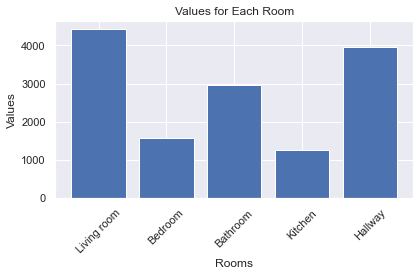

In [105]:
plt.bar(counts.index, counts.values)

plt.xlabel('Rooms')
plt.ylabel('Values')
plt.title('Values for Each Room')
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()

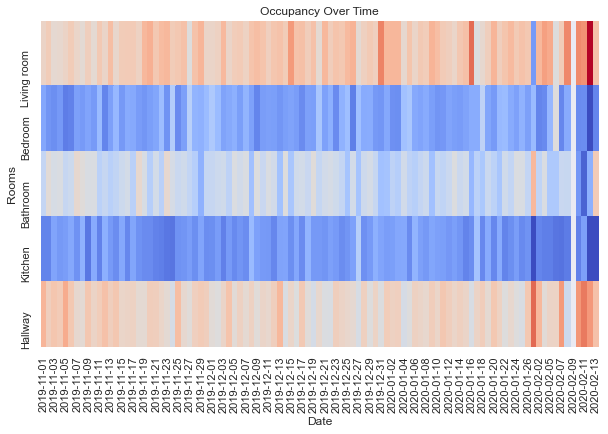

In [157]:
# Detect where a person most often goes during the day

df_pos['date'] = df_pos['datetime'].dt.date
grouped_data = df_pos.groupby('date').sum()
grouped_data['Sum'] = grouped_data['Living room'] + \
                        grouped_data['Bedroom'] + \
                        grouped_data['Bathroom'] + \
                        grouped_data['Kitchen'] + \
                        grouped_data['Hallway'] 

norm_grp_data = pd.DataFrame() 
norm_grp_data['Living room'] = grouped_data['Living room'] / grouped_data['Sum']
norm_grp_data['Bedroom'] = grouped_data['Bedroom'] / grouped_data['Sum']
norm_grp_data['Bathroom'] = grouped_data['Bathroom'] / grouped_data['Sum']
norm_grp_data['Kitchen'] = grouped_data['Kitchen'] / grouped_data['Sum']
norm_grp_data['Hallway'] = grouped_data['Hallway'] / grouped_data['Sum']

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(norm_grp_data.T, cmap='coolwarm', cbar=False)

plt.xlabel('Date')
plt.ylabel('Rooms')
plt.title('Occupancy Over Time')
plt.show()


In [141]:
# Determine the days on which there were more values
grouped_data['Sum'] = grouped_data['Living room'] + \
                        grouped_data['Bedroom'] + \
                        grouped_data['Bathroom'] + \
                        grouped_data['Kitchen'] + \
                        grouped_data['Hallway']

grouped_data.sort_values(by=['Sum'], ascending=False)

,Living room,Bedroom,Bathroom,Kitchen,Hallway,Sum
date,,,,,,
2019-12-25,129.0,59.0,63.0,34.0,107.0,392.0
2019-12-24,115.0,49.0,78.0,29.0,106.0,377.0
2020-02-08,130.0,39.0,70.0,18.0,72.0,329.0
2020-02-05,108.0,42.0,53.0,18.0,86.0,307.0
2020-02-04,99.0,20.0,66.0,16.0,70.0,271.0
...,...,...,...,...,...,...
2020-02-11,15.0,3.0,1.0,4.0,16.0,39.0
2020-01-29,2.0,3.0,7.0,0.0,9.0,21.0
2020-02-02,5.0,1.0,3.0,1.0,5.0,15.0


### df Gas exloration

In [62]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416153 entries, 0 to 416152
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      416153 non-null  object 
 1   temperature    416153 non-null  float64
 2   humidity       416153 non-null  float64
 3   CO2CosIRValue  416153 non-null  float64
 4   CO2MG811Value  416153 non-null  float64
 5   MOX1           416153 non-null  float64
 6   MOX2           416153 non-null  float64
 7   MOX3           416153 non-null  float64
 8   MOX4           416153 non-null  float64
 9   COValue        416153 non-null  float64
dtypes: float64(9), object(1)
memory usage: 31.8+ MB


In [121]:
# Display basic statistics for each parameter
statistics = df_gas.describe().T
statistics['range'] = statistics['max'] / statistics['min']
statistics

,count,mean,std,min,25%,50%,75%,max,range
temperature,416153.0,20.115751,2.295836,13.53,18.64,20.10,21.63,26.14,1.932003
humidity,416153.0,52.236446,4.343208,38.16,49.05,52.31,55.64,69.26,1.814990
CO2CosIRValue,416153.0,102.459415,39.026812,21.00,76.00,105.00,117.00,591.00,28.142857
CO2MG811Value,416153.0,539.086523,34.934361,408.00,510.00,528.00,563.00,632.00,1.549020
MOX1,416153.0,500.289413,49.795030,262.00,468.00,502.00,536.00,626.00,2.389313
MOX2,416153.0,718.708761,31.296907,514.00,703.00,719.00,738.00,808.00,1.571984
MOX3,416153.0,672.788842,36.354293,447.00,655.00,674.00,693.00,777.00,1.738255
MOX4,416153.0,609.446752,42.703923,355.00,587.00,611.00,635.00,727.00,2.047887
COValue,416153.0,120.124310,35.992508,74.00,103.00,113.00,128.00,918.00,12.405405


It can be seen that the largest range for CO2CosIRValue, COValue

Average temperature 20.12 - fits into the optimal temperature range (although the minimum is not acceptable)

The remaining indicators also fit on average into the acceptable ranges according to GOST and SanPiN

From which the conclusion is that the indicators of the apartment are normal on average, i.e. it is possible to notice anomalies

<AxesSubplot:>

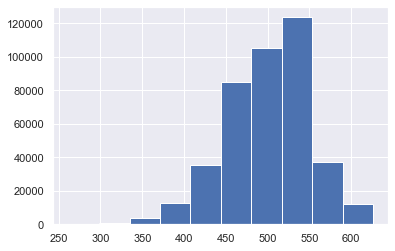

In [30]:
df_gas['MOX1'].hist()

Text(0.5, 1.0, 'CO2MG811Values')

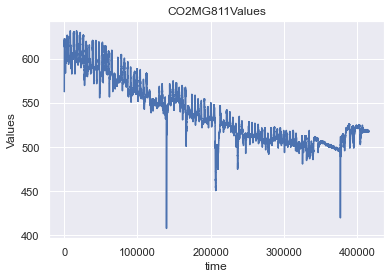

In [108]:
df_gas.CO2MG811Value.plot(kind="line")
plt.xlabel('time')
plt.ylabel('Values')
plt.title('CO2MG811Values')

Text(0.5, 1.0, 'CO2MG811Values')

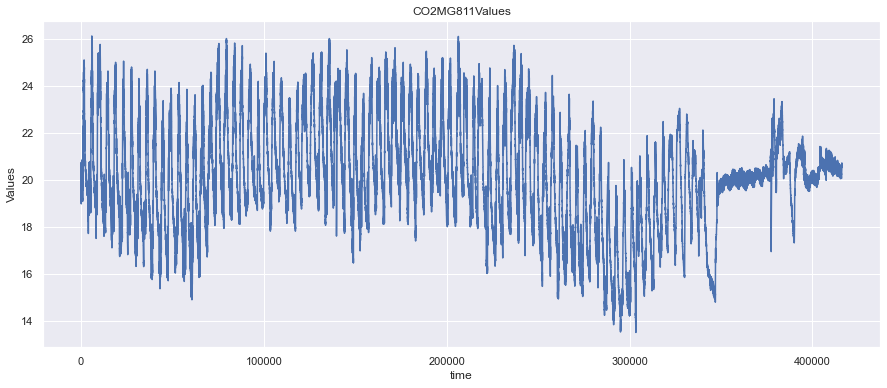

In [183]:
# Display a graph of temperature changes - first by day, then all
plt.figure(figsize=(15, 6))
df_gas.temperature.plot(kind="line")
plt.xlabel('time')
plt.ylabel('Values')
plt.title('CO2MG811Values')

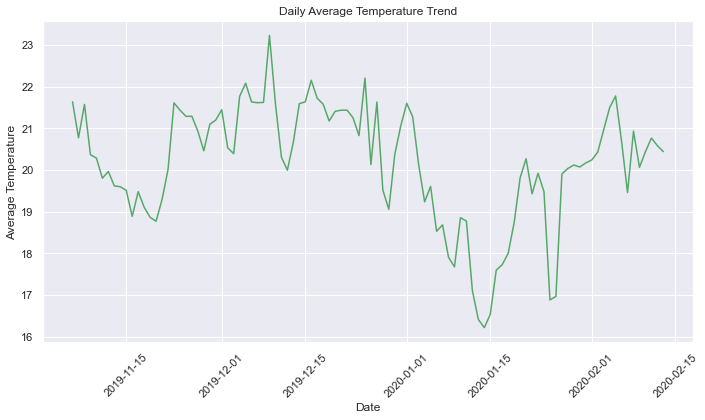

In [189]:
# Преобразование столбца 'timestamp' к типу datetime, если он еще не в таком формате
df_gas['timestamp'] = pd.to_datetime(df_gas['timestamp'])

# Группировка данных по дням и вычисление средней температуры
daily_avg_temperature = df_gas.groupby(df_gas['timestamp'].dt.date)['temperature'].mean()


plt.figure(figsize=(10, 6))
plt.plot(daily_avg_temperature.index, daily_avg_temperature.values, linestyle='-', color='g')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Daily Average Temperature Trend')
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()

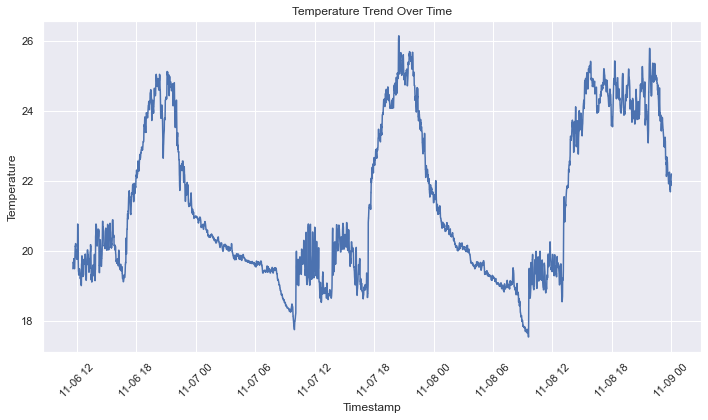

In [195]:
# Subset 3 days
subset_df = df_gas[df_gas['timestamp'].dt.date <= df_gas['timestamp'].dt.date.min() + pd.DateOffset(days=2)]


plt.figure(figsize=(10, 6))
plt.plot(subset_df['timestamp'].tolist(), subset_df['temperature'], linestyle='-', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature Trend Over Time')
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()

In [194]:
subset_df

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0
...,...,...,...,...,...,...,...,...,...,...
10863,2019-11-08 23:58:26.340268+01:00,22.07,49.95,91.0,605.0,441.0,718.0,677.0,589.0,105.0
10864,2019-11-08 23:58:46.452997+01:00,22.07,49.95,91.0,606.0,440.0,718.0,677.0,589.0,105.0
10865,2019-11-08 23:59:06.551516+01:00,22.12,49.87,91.0,605.0,440.0,718.0,677.0,589.0,104.0
10866,2019-11-08 23:59:26.632305+01:00,22.19,49.76,91.0,605.0,440.0,718.0,677.0,589.0,105.0


Temperatures are seen to drop 09:00 - 09:30

It can also be seen that after the N date the temperature range between days became smaller

In [225]:
df_ref.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0


In [227]:
# Display how many days in df_ref

df_ref['datetime'] = pd.to_datetime(df_ref['timestamp'])

df_ref['date'] = df_ref['datetime'].dt.date
unique_dates = df_ref['date'].unique()

num_of_days = len(unique_dates)

print(f"The dataset contains {num_of_days} unique days.")

The dataset contains 19 unique days.


In [229]:
# Display basic statistics for each parameter
statistics_ref = df_ref.describe().T
statistics_ref['range'] = statistics_ref['max'] / statistics_ref['min']
statistics_ref

,count,mean,std,min,25%,50%,75%,max,range
temperature,75511.0,20.025767,1.404978,14.82,19.94,20.23,20.64,23.47,1.583671
humidity,75511.0,56.690943,2.416317,46.27,55.36,57.03,58.31,69.26,1.496866
CO2CosIRValue,75511.0,70.176226,22.969229,37.00,53.00,69.00,74.00,198.00,5.351351
CO2MG811Value,75511.0,510.003523,9.233296,420.00,502.00,509.00,518.00,526.00,1.252381
MOX1,75511.0,538.731390,21.364820,339.00,530.00,537.00,545.00,598.00,1.764012
MOX2,75511.0,724.035849,19.940654,634.00,710.00,722.00,742.00,791.00,1.247634
MOX3,75511.0,675.748619,22.754632,575.00,663.00,676.00,690.00,734.00,1.276522
MOX4,75511.0,625.210473,27.964882,473.00,611.00,626.00,643.00,690.00,1.458774
COValue,75511.0,114.237290,21.903941,82.00,101.00,109.00,120.00,918.00,11.195122


Wee see the range in the reference dataset is much less than in the training one (df_gas).

## 2. Define metrics to evaluate the effectiveness of the model

### Correlation exploration

In [59]:
df_merge = df_gas
df_merge['timestamp'] = pd.to_datetime(df_gas['timestamp'])

# Convert time in df_pos to the same time zone as in df_gas
df_pos['datetime'] = df_pos['datetime'].dt.tz_localize(None)  # Удаляем временную зону
df_pos['datetime'] = df_pos['datetime'].dt.tz_localize(pytz.FixedOffset(60))  # Устанавливаем нужную временную зону

# Initialize empty columns for df_merge values
df_merge['Living room'] = None
df_merge['Bedroom'] = None
df_merge['Bathroom'] = None
df_merge['Kitchen'] = None
df_merge['Hallway'] = None

# Join tables based on closest datetime value
for index, row in df_merge.iterrows():
    # Calculate the time difference between timestamp and each datetime value in df_pos
    time_diff = (df_pos['datetime'] - row['timestamp']).abs()
    
    # Find the index of the nearest value in df_pos
    closest_index = time_diff.idxmin()
    
    # Fill the corresponding columns with values from df_pos
    df_merge.at[index, 'Living room'] = df_pos.at[closest_index, 'Living room']
    df_merge.at[index, 'Bedroom'] = df_pos.at[closest_index, 'Bedroom']
    df_merge.at[index, 'Bathroom'] = df_pos.at[closest_index, 'Bathroom']
    df_merge.at[index, 'Kitchen'] = df_pos.at[closest_index, 'Kitchen']
    df_merge.at[index, 'Hallway'] = df_pos.at[closest_index, 'Hallway']

print(df_merge)

                              timestamp  temperature  humidity  CO2CosIRValue  \
0      2019-11-06 11:37:13.038174+01:00        19.48     54.86          128.0   
1      2019-11-06 11:37:32.744996+01:00        19.59     54.23          129.0   
2      2019-11-06 11:37:53.018087+01:00        19.63     54.05          128.0   
3      2019-11-06 11:38:13.093151+01:00        19.64     53.74          128.0   
4      2019-11-06 11:38:33.032832+01:00        19.67     53.53          128.0   
...                                 ...          ...       ...            ...   
416148 2020-02-13 11:56:53.929978+01:00        20.62     57.75           62.0   
416149 2020-02-13 11:57:14.204458+01:00        20.62     57.75           62.0   
416150 2020-02-13 11:57:33.983249+01:00        20.62     57.75           62.0   
416151 2020-02-13 11:57:54.058349+01:00        20.62     57.74           63.0   
416152 2020-02-13 11:58:14.014336+01:00        20.62     57.74           63.0   

        CO2MG811Value   MOX

In [163]:
df_merge.columns

Index(['timestamp', 'temperature', 'humidity', 'CO2CosIRValue',
       'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue',
       'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway'],
      dtype='object')

In [63]:
df_merge.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,Living room,Bedroom,Bathroom,Kitchen,Hallway
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0,NaN,NaN,NaN,0,NaN
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0,NaN,NaN,NaN,0,NaN
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0,NaN,NaN,NaN,0,NaN
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0,NaN,NaN,NaN,0,NaN
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0,NaN,NaN,NaN,0,NaN


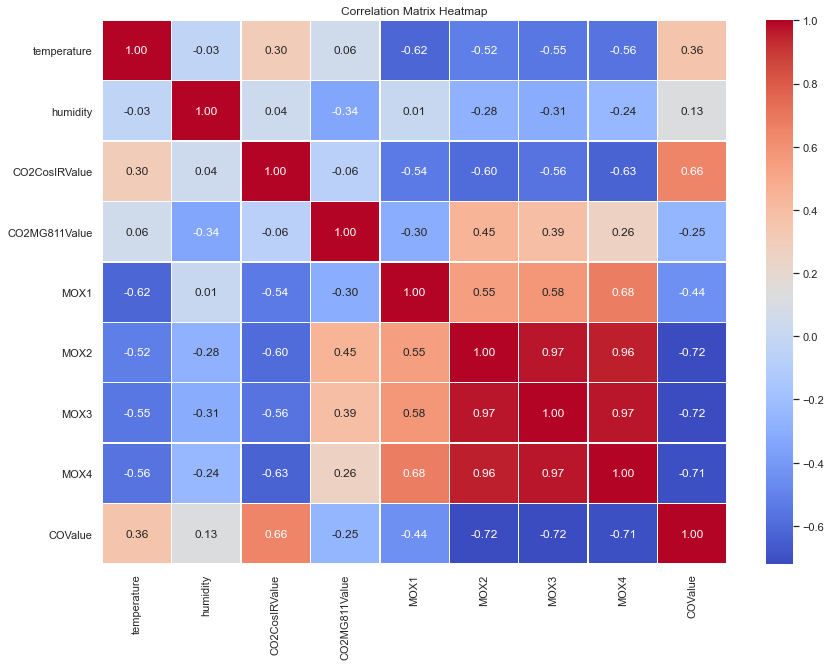

In [164]:
# Calculate the correlation matrix
correlation_matrix = df_merge.corr()

# Building a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')

# Display graph
plt.show()

Based on the research from points 1 and 2, we will select the following params:

**CO2CosIRValue**, **CO2MG811Value**, **COValue** - CO2 and CO levels:

Gas leak detection


**temperature**, **humidity**:

Sudden changes in humidity or temperature may indicate leaks or heating failure

**MOX1**, **MOX2** (gas sensors):

MOX sensors can be useful for detecting gas leaks, smoke - identifying fires or accidents

MOX3, MOX4 are highly correlated with each other - can be removed to improve model training

In [249]:
df = df_gas
df = df.drop('MOX3', axis=1)
df = df.drop('MOX4', axis=1)

## 3. Creating a baseline model

In [282]:
# Select features
# Make train and test equal
features = df.drop(['timestamp'], axis=1)
features = features.fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [254]:
df_test = df_ref
df_test = df_test.drop('MOX3', axis=1)
df_test = df_test.drop('MOX4', axis=1)

In [274]:
df_test.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,135.0


In [273]:
df.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,COValue
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,128.0
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,125.0
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,125.0
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,125.0
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,125.0


FIT MODELS

In [275]:
# Create and fit model Isolation Forest
model_IF = IsolationForest(contamination=0.1, random_state=42)
model_IF.fit(features_scaled)

IsolationForest(contamination=0.1, random_state=42)

In [257]:
# Create and fit model One-Class SVM
model_SVM = OneClassSVM(nu=0.1) 
model_SVM.fit(features_scaled)

OneClassSVM(nu=0.1)

In [293]:
from sklearn.cluster import KMeans

model_kmeans = KMeans(n_clusters=2)
predictions_kmeans = model_kmeans.fit_predict(features_scaled)

In [290]:
# Preprocessing test data
df_pred = df_test

features_test = df_test.drop(['timestamp'], axis=1)
features_test = features_test.fillna(0)
scaler = StandardScaler()
features_scaled_test = scaler.fit_transform(features_test)

TEST DATA

In [295]:
predictions_IF = model_IF.predict(features_scaled_test)
predictions_SVM = model_SVM.predict(features_scaled_test)
predictions_kmeans = model_kmeans.predict(features_scaled_test)

# 1 for norm, 0 - anomaly
predictions_binary_IF = [1 if x == -1 else 0 for x in predictions_IF]
predictions_binary_SVM = [1 if x == -1 else 0 for x in predictions_SVM]
predictions_binary_kmeans = [1 if x == -1 else 0 for x in predictions_kmeans]

# Add predictions
df_pred['anomaly_IF'] = predictions_binary_IF
df_pred['anomaly_SVM'] = predictions_binary_SVM
df_pred['anomaly_kmeans'] = predictions_binary_kmeans

Change model params

In [299]:
model_IF2 = IsolationForest(n_estimators=200, contamination=0.05)
model_IF2.fit(features_scaled)

IsolationForest(contamination=0.05, n_estimators=200)

In [300]:
predictions_IF2 = model_IF2.predict(features_scaled_test)
predictions_binary_IF2 = [1 if x == -1 else 0 for x in predictions_IF2]
df_pred['anomaly_IF2'] = predictions_IF2

Compare results

In [303]:
diff_df = df_pred[df_pred['anomaly_IF'] != df_pred['anomaly_IF2']]
print("Rows with mismatched values:")
print(diff_df)


Rows with mismatched values:
                              timestamp  temperature  humidity  CO2CosIRValue  \
29     2020-01-25 00:11:29.316080+01:00        20.50     55.64          122.0   
30     2020-01-25 00:11:49.243230+01:00        20.50     55.81          122.0   
31     2020-01-25 00:12:09.149618+01:00        20.50     55.88          122.0   
32     2020-01-25 00:12:29.161111+01:00        20.50     55.88          121.0   
33     2020-01-25 00:12:49.257957+01:00        20.50     55.81          122.0   
...                                 ...          ...       ...            ...   
75506  2020-02-13 11:56:53.929978+01:00        20.62     57.75           62.0   
75507  2020-02-13 11:57:14.204458+01:00        20.62     57.75           62.0   
75508  2020-02-13 11:57:33.983249+01:00        20.62     57.75           62.0   
75509  2020-02-13 11:57:54.058349+01:00        20.62     57.74           63.0   
75510  2020-02-13 11:58:14.014336+01:00        20.62     57.74           63.0   

In [301]:
df_pred

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,COValue,anomaly_IF,anomaly_SVM,anomaly_kmeans,anomaly_IF2
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,135.0,1,1,0,1
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,135.0,1,1,0,1
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,135.0,1,1,0,1
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,135.0,1,1,0,1
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,135.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
75506,2020-02-13 11:56:53.929978+01:00,20.62,57.75,62.0,518.0,524.0,698.0,157.0,0,0,0,1
75507,2020-02-13 11:57:14.204458+01:00,20.62,57.75,62.0,518.0,524.0,698.0,157.0,0,0,0,1
75508,2020-02-13 11:57:33.983249+01:00,20.62,57.75,62.0,518.0,524.0,698.0,157.0,0,0,0,1
75509,2020-02-13 11:57:54.058349+01:00,20.62,57.74,63.0,518.0,524.0,698.0,157.0,0,0,0,1


### Common anomalies

In [311]:
matching_rows = df_pred[df_pred[['anomaly_IF', 'anomaly_SVM', 'anomaly_kmeans']].nunique(axis=1) == 1]

# Show matching rows
print(matching_rows)

                              timestamp  temperature  humidity  CO2CosIRValue  \
6967   2020-01-26 16:18:37.197728+01:00        18.06     59.08           94.0   
6968   2020-01-26 16:18:57.472321+01:00        18.06     59.08           94.0   
6971   2020-01-26 16:19:57.585616+01:00        18.06     59.08           94.0   
6972   2020-01-26 16:20:17.349763+01:00        18.06     59.08           94.0   
6973   2020-01-26 16:20:37.502232+01:00        18.06     59.08           94.0   
...                                 ...          ...       ...            ...   
75506  2020-02-13 11:56:53.929978+01:00        20.62     57.75           62.0   
75507  2020-02-13 11:57:14.204458+01:00        20.62     57.75           62.0   
75508  2020-02-13 11:57:33.983249+01:00        20.62     57.75           62.0   
75509  2020-02-13 11:57:54.058349+01:00        20.62     57.74           63.0   
75510  2020-02-13 11:58:14.014336+01:00        20.62     57.74           63.0   

       CO2MG811Value   MOX1